In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim
from sklearn.utils import shuffle
from PIL import Image
%matplotlib inline

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [3]:
from glob import glob
class BrainMRIDataset(Dataset):
    
    def __init__(self,data_dir,reshape=True,height=128,width=128,autoencoder=False):
        self.dataDirectory = data_dir
        self.no_class = glob(data_dir+'/no/*')
        self.yes_class = glob(data_dir+'/yes/*')
        self.height = height
        self.width = width
        self.reshape=reshape
        self.autoencoder = autoencoder
        
        labels = [0 for i in range(len(self.no_class))]
        labels += [1 for i in range(len(self.yes_class))]
        
        image_links = self.no_class + self.yes_class
        self.dataframe = pd.DataFrame({
            'image':image_links,
            'labels': labels
        })
        
        self.dataframe = shuffle(self.dataframe)
        self.dataframe.reset_index(inplace=True,drop=True)
        
    def __len__(self):
        return len(self.no_class)+len(self.yes_class)
    
    def __getitem__(self,idx):
        
        image_list = self.dataframe['image'][idx]
        label_list = self.dataframe['labels'][idx]
        
        if type(image_list) == str:
            image_list = [image_list]

        if not isinstance(label_list,np.int64):
            label_list = label_list.values

        image_array = []
        for image in image_list:
            image = Image.open(image).convert("L")
            if self.reshape:
                image = image.resize((self.height,self.width))

            array = np.asarray(image)
        
            if self.autoencoder:
                array = array.reshape(self.height*self.width)
            else:
                array = array.reshape(1,self.height,self.width)
            
            image_array.append(array)
        
        return [torch.tensor(image_array,device=device),torch.tensor(label_list,device=device)]
    
    def __repr__(self):
        return str(self.dataframe.head())

In [4]:
dataset = BrainMRIDataset('D:\\ML_data_sql\\brain\\brain_tumor_dataset')
print(dataset)

                                               image  labels
0  D:\ML_data_sql\brain\brain_tumor_dataset/no\45...       0
1  D:\ML_data_sql\brain\brain_tumor_dataset/yes\Y...       1
2  D:\ML_data_sql\brain\brain_tumor_dataset/yes\Y...       1
3  D:\ML_data_sql\brain\brain_tumor_dataset/yes\Y...       1
4  D:\ML_data_sql\brain\brain_tumor_dataset/yes\Y...       1


In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,256,kernel_size=3),
            nn.MaxPool2d(2,2),
            nn.Conv2d(256,32,kernel_size=2)
        )
        self.linear1 = nn.Linear(62,128)
        self.linear2 = nn.Linear(128,64)
        self.flat = nn.Flatten(1)
        self.linear3 = nn.Linear(126976,2)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        x = self.flat(x)
        x = self.linear3(x)

        return x

In [8]:
model = CNN().to(device)
#train
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
epochs = 50
batch_size = 32
loss_list = []
for epoch in range(epochs):
    total_loss = 0
    for n in range(len(dataset)//batch_size):
    
        data,target = dataset[n*batch_size:(n+1)*batch_size]

        ypred = model.forward(data.float())
        loss = criterion(ypred,target)

        total_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
  
    loss_list.append(total_loss/batch_size)
    if epoch%10 == 0:
        print(f'Epochs: {epoch} Loss: {total_loss/n}')

Epochs: 0 Loss: 54.496978759765625
Epochs: 10 Loss: 0.6186916828155518
Epochs: 20 Loss: 0.441084086894989
Epochs: 30 Loss: 0.39933717250823975
Epochs: 40 Loss: 0.3211577832698822


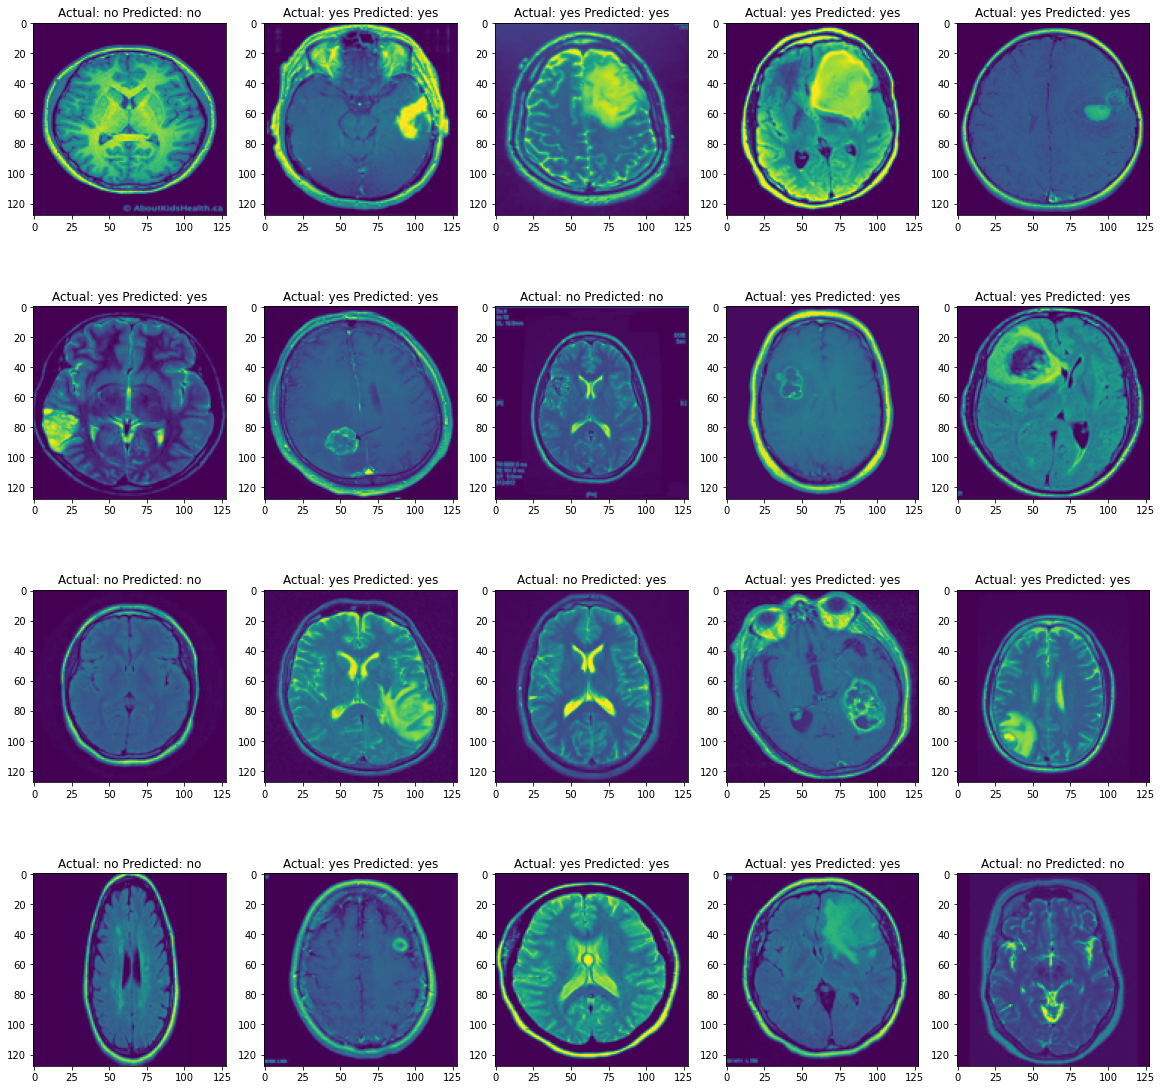

In [9]:
mapping = {0:'no',1:'yes'}
fig = plt.figure(figsize=(20,20))
for i in range(20):
    data,target = dataset[i]
    pred = model.forward(data.float())
    pred = torch.argmax(pred,dim=1)
    plt.subplot(4,5,i+1)
    plt.imshow(data[0][0].cpu())
    plt.title(f'Actual: {mapping[target.cpu().detach().item()]} Predicted: {mapping[pred.cpu().detach().item()]}')
plt.show()